<a href="https://colab.research.google.com/github/SJG0510/ML-Project/blob/main/TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

선형회귀 예측

사용 가능한 시도: 강원, 경기, 경남, 경북, 광주, 대구, 대전, 부산, 서울, 세종, 울산, 인천, 전남, 전북, 제주, 충남, 충북
예측할 시도를 입력하세요: 경기
경기의 선택 가능한 시군구: 가평군, 고양시, 고양시 덕양구, 고양시 일산동구, 고양시 일산서구, 과천시, 광명시, 광주시, 구리시, 군포시, 김포시, 남양주시, 남양주시 남양주, 남양주시 풍양, 동두천시, 부천시, 부천시 소사, 부천시 오정, 부천시 원미, 성남시, 성남시 분당구, 성남시 수정구, 성남시 중원구, 수원시, 수원시 권선구, 수원시 영통구, 수원시 장안구, 수원시 팔달구, 시흥시, 안산시, 안산시 단원구, 안산시 상록구, 안성시, 안양시, 안양시 동안구, 안양시 만안구, 양주시, 양평군, 여주시, 연천군, 오산시, 용인시, 용인시 기흥구, 용인시 수지구, 용인시 처인구, 의왕시, 의정부시, 이천시, 파주시, 평택시, 평택시 송탄, 평택시 평택, 포천시, 하남시, 화성시, 화성시 동부, 화성시 동탄, 화성시 서부
예측할 시군구를 입력하세요: 가평군
결정계수(R²): 0.934, 평균제곱오차(MSE): 0.081

실제 (2017~2024):
2017년: 8.2%
2018년: 8.0%
2019년: 8.2%
2020년: 9.8%
2021년: 9.1%
2022년: 7.6%
2023년: 11.1%
2024년: 9.0%

예측 (2025~2026):
2025년: 8.71%
2026년: 8.71%


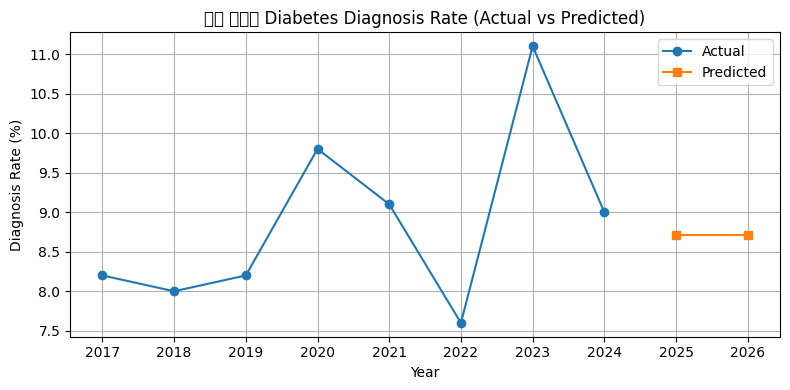

In [26]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import urllib.parse
import matplotlib.pyplot as plt
import warnings

# UserWarning 경고 무시
warnings.filterwarnings('ignore', category=UserWarning)

# GitHub에서 CSV 파일을 로드할 기본 URL 설정
BASE_URL = "https://raw.githubusercontent.com/SJG0510/ML-Project/data/"

# 건강 지표별 CSV 파일명 매핑 (컬럼명: 파일명)
FILES = {
    '흡연율': '흡연률_표준화율.csv',
    '고위험음주율': '고위험음주율_표준화율.csv',
    '비만율': '비만율_표준화율.csv',
    '스트레스율': '스트레스율_표준화율.csv',
    '우울증상율': '우울증상율_표준화율.csv',
    '당뇨병진단율': '당뇨병진단율_표준화율.csv',
}
FEATURE_COLS = list(FILES.keys())[:-1]  # 모델 입력 특성 목록
TARGET_COL = '당뇨병진단율'               # 모델 목표 변수

def load_and_prepare_data():
    """
    CSV 파일을 불러와서 wide 포맷의 연도 컬럼을 long 포맷으로 변환,
    '시도', '시군구', 'year'를 기준으로 병합한 DataFrame을 반환
    """
    dfs = []
    for col, fname in FILES.items():
        url = BASE_URL + urllib.parse.quote(fname)
        df = pd.read_csv(url, encoding='utf-8-sig')
        year_cols = [c for c in df.columns if c.isdigit()]
        if year_cols:
            df_long = df.melt(
                id_vars=['시도', '시군구'],
                value_vars=year_cols,
                var_name='year',
                value_name=col
            )
        else:
            df_long = df.rename(columns={'연도': 'year', '표준화율': col})
        df_long['year'] = df_long['year'].astype(int)
        dfs.append(df_long[['시도', '시군구', 'year', col]])
    from functools import reduce
    data = reduce(lambda left, right: pd.merge(
        left, right,
        on=['시도', '시군구', 'year'],
        how='inner'
    ), dfs)
    return data


def train_model(df):
    """
    결측치 제거 후 선형 회귀 모델을 학습,
    결정계수(R²)와 평균제곱오차(MSE)를 출력
    """
    df_clean = df.dropna(subset=FEATURE_COLS + [TARGET_COL])
    X = df_clean[FEATURE_COLS]
    y = df_clean[TARGET_COL]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    print(f"결정계수(R²): {r2_score(y, y_pred):.3f}, 평균제곱오차(MSE): {mean_squared_error(y, y_pred):.3f}")
    return model


def predict_future(model, last_row, future_years):
    """
    마지막 연도의 특성값을 기반으로
    지정된 future_years에 대한 당뇨병 진단율을 예측
    """
    df_new = pd.DataFrame(
        np.repeat(last_row.values, len(future_years), axis=0),
        columns=FEATURE_COLS,
        index=future_years
    )
    preds = model.predict(df_new)
    return dict(zip(future_years, np.round(preds, 2)))


def visualize(actual_df, preds, region):
    """
    실제 데이터 및 예측 데이터를 그래프로 시각화
    """
    # 실제 당뇨병 진단율
    years_act = actual_df['year'].tolist()
    vals_act = actual_df[TARGET_COL].tolist()
    # 예측 당뇨병 진단율
    years_pred = list(preds.keys())
    vals_pred = list(preds.values())

    plt.figure(figsize=(8, 4))
    plt.plot(years_act, vals_act, marker='o', label='Actual')   # 실제 당뇨병 진단율
    plt.plot(years_pred, vals_pred, marker='s', label='Predicted')  # 예측 당뇨병 진단율
    plt.title(f"{region} Diabetes Diagnosis Rate (Actual vs Predicted)")
    plt.xlabel('Year')  # X축 레이블 영어
    plt.ylabel('Diagnosis Rate (%)')  # Y축 레이블 영어
    plt.xticks(years_act + years_pred)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # 1. 데이터 로드
    data = load_and_prepare_data()

    # 2. 시도 선택
    provinces = sorted(data['시도'].unique())
    print("사용 가능한 시도:", ", ".join(provinces))
    province = input("예측할 시도를 입력하세요: ")
    if province not in provinces:
        print("잘못된 시도입니다.")
        exit(1)

    # 3. 해당 시도의 시군구 목록 조회 및 선택
    districts = sorted(data[data['시도'] == province]['시군구'].unique())
    print(f"{province}의 선택 가능한 시군구:", ", ".join(districts))
    district = input("예측할 시군구를 입력하세요: ")
    if district not in districts:
        print("잘못된 시군구입니다.")
        exit(1)

    # 4. 2017년 이후 데이터 필터링
    df_reg = data[
        (data['시도'] == province) &
        (data['시군구'] == district) &
        (data['year'] >= 2017)
    ].sort_values('year')
    if df_reg.empty:
        print("해당 지역의 데이터가 없습니다.")
        exit(1)

    # 5. 모델 학습 및 평가
    model = train_model(df_reg)

    # 6. 최신 연도 특성값 추출
    last_row = df_reg[df_reg['year'] == df_reg['year'].max()][FEATURE_COLS]

    # 7. 2025~2026년 예측 수행
    future_years = [2025, 2026]
    preds = predict_future(model, last_row, future_years)

    # 8. 실제 및 예측 결과 출력 (한글)
    print("\n실제 (2017~2024):")
    for y, v in zip(df_reg['year'], df_reg[TARGET_COL]):
        print(f"{y}년: {v}%")
    print("\n예측 (2025~2026):")
    for y, v in preds.items():
        print(f"{y}년: {v}%")

    # 9. 그래프로 시각화 (영어 레이블)
    visualize(df_reg, preds, f"{province} {district}")

SARIMAX 예측

사용 가능한 시도: 강원, 경기, 경남, 경북, 광주, 대구, 대전, 부산, 서울, 세종, 울산, 인천, 전남, 전북, 제주, 충남, 충북
예측할 시도를 선택하세요 ['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']: 경기
경기의 선택 가능한 시군구: 가평군, 고양시, 고양시 덕양구, 고양시 일산동구, 고양시 일산서구, 과천시, 광명시, 광주시, 구리시, 군포시, 김포시, 남양주시, 남양주시 남양주, 남양주시 풍양, 동두천시, 부천시, 부천시 소사, 부천시 오정, 부천시 원미, 성남시, 성남시 분당구, 성남시 수정구, 성남시 중원구, 수원시, 수원시 권선구, 수원시 영통구, 수원시 장안구, 수원시 팔달구, 시흥시, 안산시, 안산시 단원구, 안산시 상록구, 안성시, 안양시, 안양시 동안구, 안양시 만안구, 양주시, 양평군, 여주시, 연천군, 오산시, 용인시, 용인시 기흥구, 용인시 수지구, 용인시 처인구, 의왕시, 의정부시, 이천시, 파주시, 평택시, 평택시 송탄, 평택시 평택, 포천시, 하남시, 화성시, 화성시 동부, 화성시 동탄, 화성시 서부
예측할 시군구를 선택하세요 ['가평군', '고양시', '고양시 덕양구', '고양시 일산동구', '고양시 일산서구', '과천시', '광명시', '광주시', '구리시', '군포시', '김포시', '남양주시', '남양주시 남양주', '남양주시 풍양', '동두천시', '부천시', '부천시 소사', '부천시 오정', '부천시 원미', '성남시', '성남시 분당구', '성남시 수정구', '성남시 중원구', '수원시', '수원시 권선구', '수원시 영통구', '수원시 장안구', '수원시 팔달구', '시흥시', '안산시', '안산시 단원구', '안산시 상록구', '안성시', '안양시', '안양시 동안구', '안양시 만안구', '양주시', '양평군', '여주시', '연천군', '오산시', '용인시', '용

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


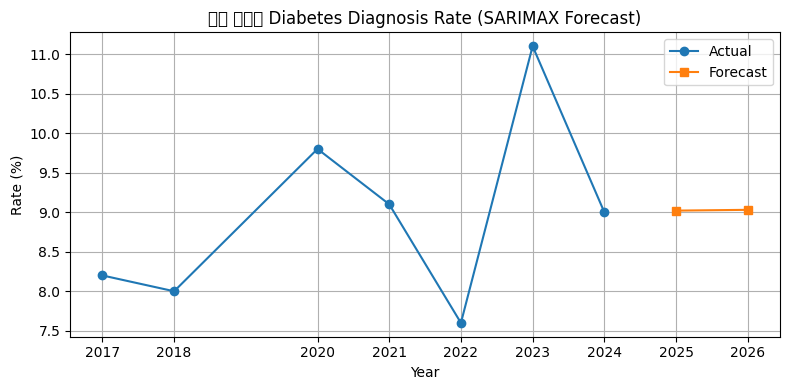

In [29]:
import pandas as pd
import numpy as np
import urllib.parse
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

# UserWarning 경고 무시
warnings.filterwarnings('ignore', category=UserWarning)

# GitHub CSV 기본 URL
BASE_URL = "https://raw.githubusercontent.com/SJG0510/ML-Project/data/"

# 지표 파일 매핑
FILES = {
    '흡연율': '흡연률_표준화율.csv',
    '고위험음주율': '고위험음주율_표준화율.csv',
    '비만율': '비만율_표준화율.csv',
    '스트레스율': '스트레스율_표준화율.csv',
    '우울증상율': '우울증상율_표준화율.csv',
    '당뇨병진단율': '당뇨병진단율_표준화율.csv',
}
FEATURE_COLS = list(FILES.keys())[:-1]
TARGET_COL = '당뇨병진단율'


def load_and_prepare_data():
    dfs = []
    for col, fname in FILES.items():
        url = BASE_URL + urllib.parse.quote(fname)
        df = pd.read_csv(url, encoding='utf-8-sig')
        year_cols = [c for c in df.columns if c.isdigit()]
        if year_cols:
            df_long = df.melt(
                id_vars=['시도','시군구'],
                value_vars=year_cols,
                var_name='year',
                value_name=col
            )
        else:
            df_long = df.rename(columns={'연도':'year','표준화율':col})
        df_long['year'] = df_long['year'].astype(int)
        dfs.append(df_long[['시도','시군구','year',col]])
    from functools import reduce
    data = reduce(lambda a, b: pd.merge(a, b, on=['시도','시군구','year']), dfs)
    return data


def fit_sarimax(df_region):
    # 결측치 제거 및 숫자형 변환
    df_clean = df_region.dropna(subset=FEATURE_COLS + [TARGET_COL]).copy()
    # 외생변수, 종속변수 numeric
    df_clean[FEATURE_COLS] = df_clean[FEATURE_COLS].apply(pd.to_numeric, errors='coerce')
    df_clean[TARGET_COL] = pd.to_numeric(df_clean[TARGET_COL], errors='coerce')
    df_clean = df_clean.dropna(subset=FEATURE_COLS + [TARGET_COL])
    endog = df_clean[TARGET_COL]
    exog = df_clean[FEATURE_COLS]
    # SARIMAX 모델 정의
    model = SARIMAX(
        endog,
        exog=exog,
        order=(1,1,1),
        seasonal_order=(0,0,0,0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    print(res.summary())
    return res, df_clean


def forecast_sarimax(res, df_clean, future_years):
    """
    SARIMAX 모델 결과로 미래 연도 예측값 생성 후
    비현실적 음수나 0% 예측을 막기 위해 최소값을 마지막 실제값으로 조정
    """
    # 마지막 연도 외생변수 값 추출 및 float 변환
    last_exog = df_clean[FEATURE_COLS].iloc[-1].astype(float).values.reshape(1, -1)
    future_exog = np.repeat(last_exog, len(future_years), axis=0)
    # 예측 수행
    pred = res.get_forecast(steps=len(future_years), exog=future_exog)
    mean_forecast = pred.predicted_mean.round(2)
    # 마지막 실제값 확보
    last_actual = df_clean[TARGET_COL].iloc[-1]
    # 예측값이 마지막 실제값보다 작으면 마지막 실제값으로 대체
    mean_forecast = np.where(mean_forecast < last_actual, last_actual, mean_forecast)
    return dict(zip(future_years, mean_forecast))


def visualize_ts(df_region, preds, region):
    years = df_region['year'].tolist() + list(preds.keys())
    vals = df_region[TARGET_COL].tolist() + list(preds.values())
    plt.figure(figsize=(8,4))
    plt.plot(df_region['year'], df_region[TARGET_COL], marker='o', label='Actual')
    plt.plot(list(preds.keys()), list(preds.values()), marker='s', label='Forecast')
    plt.title(f"{region} Diabetes Diagnosis Rate (SARIMAX Forecast)")
    plt.xlabel('Year')
    plt.ylabel('Rate (%)')
    plt.xticks(years)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    data = load_and_prepare_data()

    # 시도 선택
    provinces = sorted(data['시도'].unique())
    print("사용 가능한 시도:", ", ".join(provinces))
    province = input(f"예측할 시도를 선택하세요 {provinces}: ")
    if province not in provinces:
        print("잘못된 시도입니다.")
        exit(1)

    # 시군구 선택
    districts = sorted(data[data['시도'] == province]['시군구'].unique())
    print(f"{province}의 선택 가능한 시군구:", ", ".join(districts))
    district = input(f"예측할 시군구를 선택하세요 {districts}: ")
    if district not in districts:
        print("잘못된 시군구입니다.")
        exit(1)

    # 데이터 필터링
    df_region = data[
        (data['시도'] == province) &
        (data['시군구'] == district) &
        (data['year'] >= 2017)
    ].sort_values('year')
    if df_region.empty:
        print("해당 지역의 데이터가 없습니다.")
        exit(1)

    # 모델 학습 및 예측
    res, df_clean = fit_sarimax(df_region)
    future_years = [2025, 2026]
    preds = forecast_sarimax(res, df_clean, future_years)

    # 결과 출력
    print("\n실제 (2017~2024):")
    for y, v in zip(df_clean['year'], df_clean[TARGET_COL]):
        print(f"{y}년: {v}%")
    print("\n예측 (2025~2026):")
    for y, v in preds.items():
        print(f"{y}년: {v}%")

    # 시각화
    visualize_ts(df_clean, preds, f"{province} {district}")